# Differentiation

The first tutorial dealt with all similarities between NumPy and TensorFlow (tensors vs arrays, tensorflow ops vs numpy ops, etc). In this light, TensorFlow was portrayed as a less-friendly version of NumPy. 

This tutorial will focus on one of the key features of TensorFlow: differentiation, i.e. the ability to compute the gradient of any operation. This is necessary for training Neural Networks, as we'll see in a future tutorial. To accomplish this TensorFlow uses a technique called [reverse-mode automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation).

The main API we can use to compute the gradient of one or more operations is [`tf.GradientTape`](https://www.tensorflow.org/api_docs/python/tf/GradientTape). This defines a context, within which opeations are recorded. TensorFlow then uses auto-differentiation to compute the gradient of these operations w.r.t some tensor(s).

For example, suppose we have a function:

$$
f(x) = x^2 - 3x + 1
$$

and we want to compute its gradient w.r.t $x$, for $x = 2$:

$$
\frac{df}{dx}\bigg\rvert_{x=2}
$$

In [1]:
!pip install --upgrade tensorflow
import tensorflow as tf
assert tf.__version__[0] == '2', 'this tutorial is for tensorflow versions of 2 or higher'

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.1.0)


In [2]:
x = tf.Variable([2], dtype=tf.float32)
with tf.GradientTape() as tape:  # define a context, within which TensorFlow will record operations
  tape.watch(x)  # monitor the operations involving the tensor x
  f = x ** 2 - 3 * x + 1  # perform the operation inside the context

df = tape.gradient(f, x)  # compute the gradiend of f w.r.t x (i.e. df/dx)

print('f(2) =', f.numpy()[0])
print('df/dx for (x=2) is', df.numpy()[0])

f(2) = -1.0
df/dx for (x=2) is 1.0


As expected:

$$
\frac{df}{dx}\bigg\rvert_{x=2} = 2x - 3\rvert_{x=2} = 1
$$

TensorFlow watches all `tf.Variable`s by default so the `tape.watch(x)` commend was redundant before. Let's write it a bit better and do a few more computations.

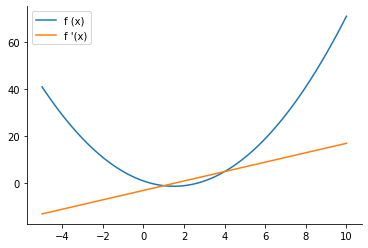

In [53]:
def f(x):
  return x ** 2 - 3 * x + 1

x2 = tf.Variable(np.linspace(-5, 10, 100), dtype=tf.float32)

with tf.GradientTape() as tape:
  y = f(x2) 

dy = tape.gradient(y, x2)


ax  = plt.subplot(111)
ax.plot(x2.numpy(), y.numpy(), label='f (x)')
ax.plot(x2.numpy(), dy.numpy(), label='f \'(x)')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()


If you want to disable this functionality and select specifically what `tf.GradientTape()` monitors, you can pass the argument `watch_accessed_variables=False` to its constructor. This can be useful when performing computations on large models, where you don't want to update some parameters.

In [67]:
with tf.GradientTape(watch_accessed_variables=False) as tape:
  tape.watch(x)
  y = f(x)
  y2 = f(x2)  # not being recorded

print('dy2/dx2 =', tape.gradient(y2, x2))

dy2/dx2 = None


This can be useful for saving memory, as no resources were allocated to store the operations involving `x2`.

Explicitly telling `tf.GradientTape` what to watch requires a bit of caution because we need to make sure that the variable exists when we call `.watch()`. There are some scenarios where this might be tricky. One such example can be found at the `tf.GradientTape`'s [documentation page](https://www.tensorflow.org/api_docs/python/tf/GradientTape).

`tf.GradientTape` holds its resources, by default, **only** until the `.gradient()` method is called. 

In [4]:
with tf.GradientTape() as tape:
  f = x ** 2 - 3 * x + 1

df = tape.gradient(f, x)
df = tape.gradient(f, x)

RuntimeError: ignored

To create a persistent tape, whose `.gradient()` method can be called multiple times, pass the argument `persistent=True` to the tape.

In [0]:
with tf.GradientTape(persistent=True) as tape:
  f = x ** 2 - 3 * x + 1

df = tape.gradient(f, x)
df = tape.gradient(f, x)

To release the resources just drop all references to the tape so that it can be garbage collected.

In [0]:
del tape

`tf.GradientTape` handles Python's control flow naturally. This can be confirmed through a few examples.  

In [0]:
# Loops
with tf.GradientTape(persistent=True) as tape:
  y1 = x * x * x * x * x     # x ** 5

  y2 = 1
  for _ in range(5):
    y2 *= x                  # same thing calculated iteratively in a for loop
  
  i = 0
  y3 = 1
  while i < 5:
    y3 *= x                  # same thing in a while loop
    i += 1

# Check if the 3 gradients are the same
assert tape.gradient(y1, x) == tape.gradient(y2, x)
assert tape.gradient(y1, x) == tape.gradient(y3, x)

# Conditions
with tf.GradientTape() as tape2:
  y4 = 1
  for i in range(10):
    if i % 2:
      y4 *= x  # only multiply for odd i's

# We have 5 odd i's in the range [0, 9] (i.e. 1, 3, 5, 7, 9), so we expect
# y4 = x * x * x * x * x. This means that y4 should be the same as y1
assert tape.gradient(y1, x) == tape2.gradient(y4, x)

# Recursion
def rec(x, y=1, i=0):
  '''
  A dumb recursion that multiplies x with itself 5 times.
  '''
  if i < 5:
    return rec(x, y*x, i+1)
  else:
    return y

with tf.GradientTape() as tape3:
  y5 = rec(x)

# Since the recursion essentially did y5 = x * x * x * x * x, y5's gradient
# should be the same as y1's.
assert tape.gradient(y1, x) == tape3.gradient(y5, x)

print('All cleared!')

Another feature of `tf.GradientTape` is that it can record the computation of gradients. This means that if we nest two tape contexts and record the inner context's `.gradient()` we can compute **higher-order gradients**!

We'll use the function 

$$
f(x) = 5x^3 - 4x^2 + 2x - 3 \\
\frac{df}{dx} = 15x^2 - 8x + 2 \\
\frac{d^2f}{dx} = 30x - 8
$$


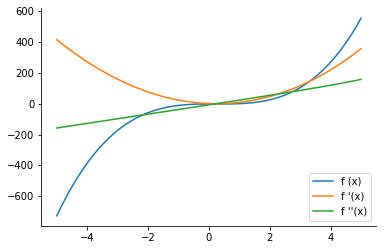

In [41]:
def f(x):
  return 5 * x ** 3 - 4 * x ** 2 + 2 ** x - 3

x2 = tf.Variable(np.linspace(-5, 5, 100), dtype=tf.float32)

with tf.GradientTape() as outer_tape:

  with tf.GradientTape() as inner_tape:

    y = f(x2)

  dy = inner_tape.gradient(y, x2)  # compute the first-order derivative of y w.r.t x

d2y = outer_tape.gradient(dy, x2)  # compute the second-order derivative of y w.r.t x

ax  = plt.subplot(111)
ax.plot(x2.numpy(), y.numpy(), label='f (x)')
ax.plot(x2.numpy(), dy.numpy(), label='f \'(x)')
ax.plot(x2.numpy(), d2y.numpy(), label='f \'\'(x)')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()

Another thing to keep in mind is that we can stop the recording of operations inside the context of a `tf.GradientTape()` with the `.stop_recording()` method, which is used as its own context.

```python
with tf.GradientTape() as tape:
  y1 = f1(x)
  with tape.stop_recording():
    y2 = f2(x)  # this operation is not recorded
  y3 = f3(x)
```

This can be useful to save memory.